# Импорт библиотек

In [1]:
import pandas as pd
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SequentialFeatureSelector_mlx
from sklearn.feature_selection import SelectFromModel


# Загрузка и подготовка данных. Вариант 5

In [2]:
data = StringIO('''Команда;Победы;E.R.A.;Пропущенные удары;Защита
Anaheim; 99; 3.69; 1345; 54
Baltimore; 67; 4.46; 1491; 31
Boston; 93; 3.75; 1339; 51
Chicago White Sox; 81; 4.53; 1422; 35
Cleveland; 74; 4.91; 1508; 34
Detroit; 55; 4.93; 1593; 33
Kansas City; 62; 5.21; 1587; 30
Minnesota; 94; 4.12; 1454; 47
New York Yankees; 103; 3.87; 1441; 53
Oakland; 103; 3.68; 1391; 48
Seattle; 93; 4.07; 1422; 43
Tampa Bay; 55; 5.29; 1567; 25
Texas; 72; 5.15; 1528; 33
Toronto; 78; 4.8; 1504; 41
Arizona; 98; 3.92; 1361; 40
Atlanta; 101; 3.13; 1302; 57
Chicago Cubs; 67; 4.29; 1373; 23
Cincinnati; 78; 4.27; 1502; 42
Colorado; 73; 5.2; 1554; 43
Florida; 79; 4.36; 1449; 36
Houston; 84; 4; 1423; 43
Los Angeles; 92; 3.69; 1311; 56
Milwaukee; 56; 4.73; 1468; 32
Montreal; 83; 3.97; 1475; 39
New York Mets; 75; 3.89; 1408; 36
Philadelphia; 80; 4.17; 1381; 47
Pittsburgh; 72; 4.23; 1447; 47
St. Louis; 97; 3.7; 1355; 42
San Diego; 66; 4.62; 1522; 40
San Francisco; 95; 3.54; 1349; 43
''')

df = pd.read_csv(data, sep=';', index_col='Команда')
df.head()

,Победы,E.R.A.,Пропущенные удары,Защита
Команда,,,,
Anaheim,99,3.69,1345,54
Baltimore,67,4.46,1491,31
Boston,93,3.75,1339,51
Chicago White Sox,81,4.53,1422,35
Cleveland,74,4.91,1508,34


In [3]:
df.corr()

,Победы,E.R.A.,Пропущенные удары,Защита
Победы,1.000000,-0.822721,-0.749884,0.783992
E.R.A.,-0.822721,1.000000,0.893497,-0.703790
Пропущенные удары,-0.749884,0.893497,1.000000,-0.598100
Защита,0.783992,-0.703790,-0.598100,1.000000


# Обозначаем независимые и зависимый столбцы

In [4]:
df.columns
df.rename(columns={
    'E.R.A.':           'xi1',
    'Пропущенные удары':'xi2',
    'Защита':           'xi3',
    'Победы':           'yi'
}, inplace=True)
df.head()

,yi,xi1,xi2,xi3
Команда,,,,
Anaheim,99,3.69,1345,54
Baltimore,67,4.46,1491,31
Boston,93,3.75,1339,51
Chicago White Sox,81,4.53,1422,35
Cleveland,74,4.91,1508,34


# Строим модель линейной множественной регрессии

In [5]:
# Определяем зависимую переменную (yi) и независимые переменные (xi1, xi2, xi3, xi4, xi5)
Y = df['yi']
X = df[['xi1', 'xi2', 'xi3']]

# Создаем модель линейной регрессии
model = LinearRegression()

# Обучаем модель
model.fit(X, Y)

# Получаем предсказания модели
predictions = model.predict(X)

# Оцениваем адекватность модели
mse = mean_squared_error(Y, predictions)
r2 = r2_score(Y, predictions)

# Коэффициенты модели
coefficients = model.coef_
intercept = model.intercept_

(mse, r2, coefficients, intercept)

(49.6899614701074,
 0.7638372174208715,
 array([-10.68768688,  -0.02455932,   0.69903852]),
 133.3982792813986)

Результаты, которые вы предоставили, представляют собой параметры модели линейной множественной регрессии, построенной на основе ваших данных. Давайте проанализируем их:

1.  **Среднеквадратичная ошибка (MSE)**: Значение MSE равно 49.7. Это показатель ошибки модели, который измеряет среднюю разницу между фактическими значениями и предсказаниями модели. Чем меньше значение MSE, тем лучше модель предсказывает результаты. В вашем случае, MSE относительно высокое, но для полной оценки необходимо сравнить его с диапазоном значений зависимой переменной (yi).
    
2.  **Коэффициент детерминации (R²)**: Значение R² равно 0.76. Этот коэффициент показывает, какая доля изменчивости зависимой переменной объясняется независимыми переменными модели. В данном случае, около 76% вариативности суммы продаж можно объяснить через выбранные факторы. Это незначительная доля.
    
3.  **Коэффициенты модели**: Массив коэффициентов \[-10.7,  -0.025,   0.7\] соответствует влиянию каждого из факторов xi1, xi2, xi3 (E.R.A., Пропущенные удары, Защита)соответственно.

4.  **Константа (intercept)**: Значение константы 133 представляет собой ожидаемое значение кол-ва побед в сезоне, когда все независимые переменные равны нулю. Она служит начальной точкой для линейного уравнения.

### Выводы:

*   Модель демонстрирует низкую способность объяснять изменения урожайности зерновых культур, так как R² составляет около 76%.
*   Отрицательные коэффициенты у некоторых переменных говорят о том, что увеличение этих факторов может негативно сказаться победах. (например E.R.A.)

# Вычиление и анализ матрицы корреляций для незасимых переменных

In [6]:

# Вычисляем матрицу корреляций для объясняющих переменных
RXX = X.corr()

# Вычисляем определитель матрицы корреляций
det_RXX = np.linalg.det(RXX)

# Проверяем гипотезу о наличии мультиколлинеарности
# Степени свободы для хи-квадрат распределения
Df = len(X.columns) * (len(X.columns) - 1) / 2

# Вычисляем статистику теста
chi2_stat = -((len(X) - 1) - (2 * len(X.columns) + 5) / 6) * np.log(det_RXX)

# Вычисляем критическое значение для хи-квадрат распределения с уровнем значимости 0.05
chi2_critical = chi2.ppf(0.95, Df)

display(RXX)
(det_RXX, chi2_stat, chi2_critical, chi2_stat > chi2_critical)

,xi1,xi2,xi3
xi1,1.000000,0.893497,-0.70379
xi2,0.893497,1.000000,-0.59810
xi3,-0.703790,-0.598100,1.00000


(0.10083013558473748, 62.328972439050794, 7.814727903251179, True)

Результаты вывода включают в себя, по проядку: матрицу выборочных парных коэффициентов корреляции (RXX) между объясняющими переменными, определитель этой матрицы, статистику хи-квадрат, критическое значение хи-квадрат при уровне значимости 0.05, и логическое значение, указывающее на наличие или отсутствие мультиколлинеарности. Давайте проанализируем эти результаты:

### Анализ матрицы корреляций (RXX):

*   Высокие значения корреляции наблюдаются между некоторыми переменными, особенно между xi1 и xi2. Это указывает на сильную линейную зависимость между этими парами переменных.

### Анализ определителя матрицы корреляций:

*   Определитель матрицы RXX равен 0.1, что очень близко к нулю. Это говорит о том, что матрица корреляций почти вырождена, что является признаком мультиколлинеарности.

### Анализ хи-квадрат статистики:

*   Статистика хи-квадрат равна 62, что выше критического значения при уровне значимости 0.05.
*   Так как статистическое значение больше критического, мы принимаем гипотезу о наличии мультиколлинеарности.

### Выводы:

*   На основе представленных данных можно сделать вывод, что в модели присутствует мультиколлинеарность. Это означает, что некоторые объясняющие переменные сильно коррелированы друг с другом, что может привести к проблемам в оценке коэффициентов регрессии и их интерпретации.
*   Для улучшения модели следует рассмотреть возможность исключения одной или нескольких переменных, которые сильно коррелированы с другими, или использовать методы, устойчивые к мультиколлинеарности, такие как гребневая регрессия (ridge regression).

# Анализ значимых незасимых переменных тремя разными методами. Выбор наиболее подходящих для устранения или уменьшения мультиколлинеарности

,yi,xi1,xi2,xi3
yi,1.000000,-0.822721,-0.749884,0.783992
xi1,-0.822721,1.000000,0.893497,-0.703790
xi2,-0.749884,0.893497,1.000000,-0.598100
xi3,0.783992,-0.703790,-0.598100,1.000000


Выбранные фичи (Select From Model): ['xi1']
Выбранные фичи (Sequential Feature Selector): ['xi1']
Выбранные фичи (Sequential Feature Selector) mlx model: ('xi1', 'xi3')


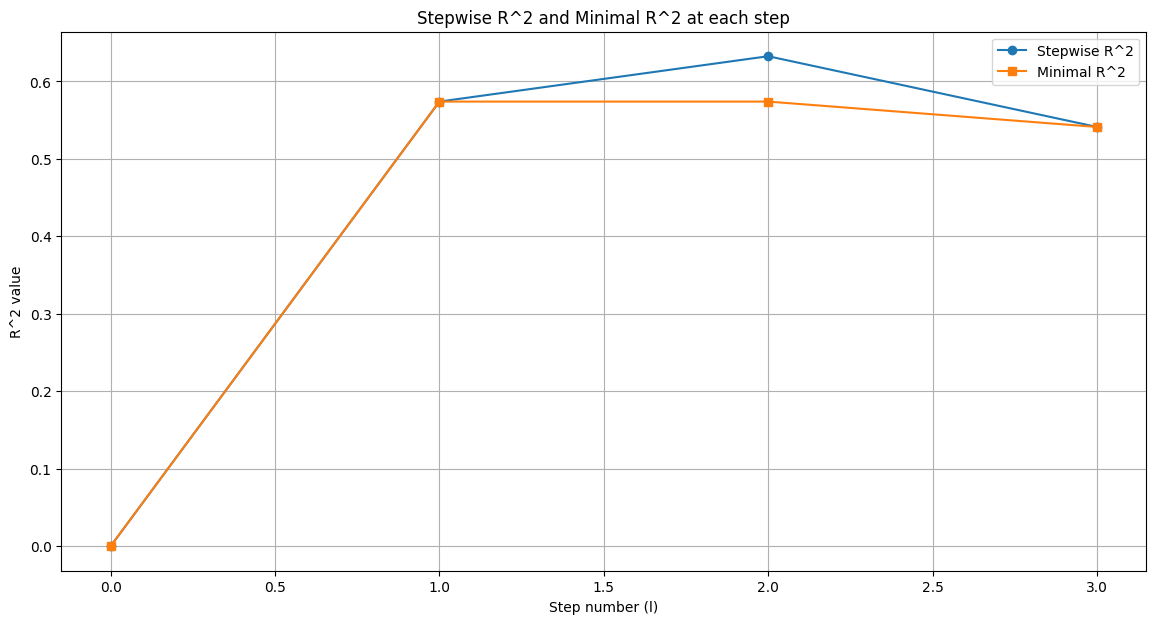

In [7]:
display(df.corr())

# Определяем независимые переменные (X) и зависимую переменную (y)
X = df[['xi1', 'xi2', 'xi3']]
y = df["yi"]

# Настраиваем Select From Model
sfm = SelectFromModel(model).fit(X, y)
X_new = sfm.transform(X)

print(f'Выбранные фичи (Select From Model): {sfm.get_feature_names_out()}')


sfs = SequentialFeatureSelector(LinearRegression(),
          n_features_to_select='auto',
          direction ='forward').fit(X,y)

print(f'Выбранные фичи (Sequential Feature Selector): {sfs.get_feature_names_out()}')

sfs_mlx = SequentialFeatureSelector_mlx(LinearRegression(),
          k_features='best', forward=False).fit(X,y)
print(f'Выбранные фичи (Sequential Feature Selector) mlx model: {sfs_mlx.k_feature_names_}')



# Получаем результаты
stepwise_r2_results = sfs_mlx.subsets_

# Извлекаем R^2 для каждого шага
r2_per_step = [stepwise_r2_results[i]['avg_score'] for i in stepwise_r2_results.keys()]
r2_min_at_steps = [min(r2_per_step[:i+1]) for i in range(len(r2_per_step))]

# Добавляем начальный шаг, где R^2 равен нулю
r2_per_step = [0] + r2_per_step
r2_min_at_steps = [0] + r2_min_at_steps

# Теперь строим графики R^2 и минимальных значений R^2 на каждом шаге
steps = list(range(len(r2_per_step)))

plt.figure(figsize=(14, 7))

# Строим график R^2 на каждом шаге
plt.plot(steps, r2_per_step, 'o-', label='Stepwise R^2')

# Строим график минимальных значений R^2 на каждом шаге
plt.plot(steps, r2_min_at_steps, 's-', label='Minimal R^2')

# Добавляем метки и заголовок
plt.xlabel('Step number (l)')
plt.ylabel('R^2 value')
plt.title('Stepwise R^2 and Minimal R^2 at each step')
plt.legend()
plt.grid(True)
plt.show()

# выбираем независимые параметры 'xi1', 'xi3'

In [8]:
# Обучение модели линейной регрессии с использованием отобранных переменных
# Предполагаем, что все переменные отобраны, так как не указаны конкретные отобранные предикторы

X = sfs_mlx.transform(X)
y = df["yi"]


# Создание модели линейной регрессии
lr_final = LinearRegression()

# Обучение модели на данных
lr_final.fit(X, y)

# Получение коэффициента детерминации R^2 для оценки адекватности модели
r2_score_final = lr_final.score(X, y)

# Вычисление прогнозов для оценки модели
y_pred = lr_final.predict(X)

# Оценка адекватности модели также может включать F-тест
from sklearn.feature_selection import f_regression

# Получение F-статистики и соответствующих p-значений
f_statistic, p_values = f_regression(X, y)

# Вывод результата
r2_score_final, f_statistic, p_values


(0.7601158216140617,
 array([58.65248418, 44.66007448]),
 array([2.42012186e-08, 2.97557214e-07]))

Для построения выборочного уравнения линейной множественной регрессии с использованием только отобранных предикторов, нужно выполнить следующие шаги:

1.  Создать модель линейной регрессии на основе выбранных переменных.
2.  Обучить модель на данных.
3.  Оценить адекватность модели, рассчитав коэффициент детерминации R2R^2R2 и, возможно, другие статистики, такие как F-статистику.
4.  Сделать выводы на основе полученных оценок адекватности.

В предыдущих шагах мы уже отобрали переменные и создали модель регрессии. Теперь можно использовать эти переменные для построения окончательной регрессионной модели и оценки её адекватности.

F-статистика и соответствующие p-значения для каждого предиктора следующие:

*   xi1: F-статистика = 58.7, p-значение = 0
*   xi3: F-статистика = 44.7, p-значение = 0

**Вывод:** P-значения указывают на статистическую значимость коэффициентов при уровне значимости 0.05. По этим данным можно увидеть, что предикторы xi1 и xi3 являются статистически значимыми, так как их p-значение меньше 0.05.

Важно отметить, что F-тест в целом проверяет, значимо ли отличается коэффициент регрессии от нуля для всей модели, а не для каждого предиктора в отдельности. Для более точного анализа значимости отдельных предикторов следует рассмотреть t-тесты коэффициентов регрессии.
